In [1]:
import pandas as pd
import numpy as np

from pandasql import sqldf

import plotly.express as px

Python
1. Преобразовать данные там, где это необходимо
2. Построить когортный retention rate (когорта - yyyymm)
3. Посчитать когортный repurchase в 1 - 10 покупку
4. Построить график среднего чека по категориям товаров

SQL
Повторить пункты 2-3 на SQL

### Предпроцессинг

Читаем данные

In [2]:
df = pd.read_csv('jewelry.csv', names = ['order_time','order_id','product_id',
                                         'sku_qty','category_id','category',
                                         'brand_id','price','user_id','gender',
                                         'c1','c2','c3'])
df.head()

,order_time,order_id,product_id,sku_qty,category_id,category,brand_id,price,user_id,gender,c1,c2,c3
0,2018-12-01 11:40:29 UTC,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond
4,2018-12-02 21:30:19 UTC,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst


In [3]:
df.shape

(95911, 13)

In [4]:
df.dtypes

order_time      object
order_id         int64
product_id       int64
sku_qty          int64
category_id    float64
category        object
brand_id       float64
price          float64
user_id        float64
gender          object
c1              object
c2              object
c3              object
dtype: object

Поменяем тип данных order time

In [5]:
df['order_time'] = pd.to_datetime(df['order_time'])

Посмотрим на пропущенные значения

In [6]:
df.isna().sum()

order_time         0
order_id           0
product_id         0
sku_qty            0
category_id     5352
category        9933
brand_id        4785
price           5352
user_id         5352
gender         48168
c1              7660
c2              5462
c3             34058
dtype: int64

Мы видим, что в датафрейме есть большое количество пропусков, но удалим мы пропуски только для колонки user_id  , потому что для вопросов 2 и 3 нам понадобится только колонки order_time, order_id и user_id 

In [7]:
df.dropna(subset = ['user_id'], inplace = True)

Проверим данные на дубликаты

In [8]:
df[df.duplicated()].shape

(2469, 13)

Мы видим, что в данных есть дубли.
Удалим их

In [9]:
df.drop_duplicates(inplace = True)
df.shape

(88090, 13)

Посмотрим на описательные статистики

In [10]:
df.describe()

,order_id,product_id,sku_qty,category_id,brand_id,price,user_id
count,8.809000e+04,8.809000e+04,88090.0,8.809000e+04,83415.000000,88090.000000,8.809000e+04
mean,2.477624e+18,1.832196e+18,1.0,1.805950e+18,0.598837,363.586043,1.512610e+18
std,1.931318e+17,2.071276e+17,0.0,2.080090e+16,0.698200,448.342039,2.384234e+16
min,1.924719e+18,1.313551e+18,1.0,1.313678e+18,0.000000,0.990000,1.313554e+18
25%,2.373429e+18,1.806829e+18,1.0,1.806829e+18,0.000000,143.700000,1.515916e+18
50%,2.516750e+18,1.956664e+18,1.0,1.806829e+18,0.000000,259.970000,1.515916e+18
75%,2.637983e+18,1.956664e+18,1.0,1.806829e+18,1.000000,431.370000,1.515916e+18
max,2.719022e+18,2.541962e+18,1.0,1.806829e+18,6.000000,34448.600000,1.554297e+18


Отрицательных значений нигде нет, данным пока можем доверять

### Retention 

#### Решим через pandas

Описание подхода

Retention будем рассчитывать по факту покупки в рамках месяца 

Присоединими к каждому пользователю дату его первой покупки

In [11]:
first_purch = df.groupby('user_id', as_index = False)\
        .agg({'order_time': 'min'})\
        .rename(columns = {'order_time': 'first_purchase'})

retention = df.merge(first_purch, how = 'left', on = 'user_id')
retention.head()

,order_time,order_id,product_id,sku_qty,category_id,category,brand_id,price,user_id,gender,c1,c2,c3,first_purchase
0,2018-12-01 11:40:29+00:00,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond,2018-12-01 11:40:29+00:00
1,2018-12-01 17:38:31+00:00,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN,2018-12-01 17:38:31+00:00
2,2018-12-02 13:53:42+00:00,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire,2018-12-02 13:53:42+00:00
3,2018-12-02 17:44:02+00:00,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond,2018-12-02 17:44:02+00:00
4,2018-12-02 21:30:19+00:00,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst,2018-12-02 21:30:19+00:00


Переведем даты покупок в месяцы

In [12]:
retention ['order_month'] = pd.to_datetime(retention.order_time.apply(lambda x: str(x)[:7] + '-01'))
retention ['first_purchase'] = pd.to_datetime(retention.first_purchase.apply(lambda x: str(x)[:7] + '-01'))

Считаем количество клиентов с покупками для каждого месяца по месяцу регистрации

In [13]:
order_month_by_first = retention.groupby(['first_purchase', 'order_month'], as_index = False )\
                        .agg({'user_id': 'nunique'})

order_month_by_first.head()

,first_purchase,order_month,user_id
0,2018-12-01,2018-12-01,66
1,2018-12-01,2019-01-01,19
2,2018-12-01,2019-02-01,24
3,2018-12-01,2019-03-01,17
4,2018-12-01,2019-04-01,16


Считаем количество зарегестрированных клиентов для каждого месяца

In [14]:
total_by_first = retention.groupby(['first_purchase'], as_index = False )\
                .agg({'user_id': 'nunique'})\
                .rename(columns = {'user_id': 'total_users_from_first_month'})

total_by_first.head()

,first_purchase,total_users_from_first_month
0,2018-12-01,66
1,2019-01-01,188
2,2019-02-01,212
3,2019-03-01,206
4,2019-04-01,153


In [15]:
retention = order_month_by_first.merge(total_by_first, how = 'left', on = ['first_purchase'])
retention.head()

,first_purchase,order_month,user_id,total_users_from_first_month
0,2018-12-01,2018-12-01,66,66
1,2018-12-01,2019-01-01,19,66
2,2018-12-01,2019-02-01,24,66
3,2018-12-01,2019-03-01,17,66
4,2018-12-01,2019-04-01,16,66


Для каждого месяца покупки посчитаем номер месяца после месяца регистрации

In [16]:
finish = retention.order_month.dt.to_period('M').view(dtype='int64')
start = retention.first_purchase.dt.to_period('M').view(dtype='int64')

retention['month_aftet_reg'] = finish - start

Считаем retention
Смотреть retention будем только для 12 месяцев после покупки

In [17]:
retention['retention'] = round(retention['user_id'] / retention['total_users_from_first_month'] * 100, 2)

In [18]:
retention = retention.query('month_aftet_reg <= 12')\
    .pivot(index = 'first_purchase', columns = 'month_aftet_reg', values = 'retention')
retention

month_aftet_reg,0,1,2,3,4,5,6,7,8,9,10,11,12
first_purchase,,,,,,,,,,,,,
2018-12-01,100.0,28.79,36.36,25.76,24.24,22.73,28.79,27.27,27.27,19.70,21.21,30.30,31.82
2019-01-01,100.0,23.94,18.62,17.55,14.36,12.23,13.83,13.83,11.70,18.62,21.28,22.34,17.55
2019-02-01,100.0,12.26,9.91,8.96,5.66,10.85,9.43,7.55,10.85,10.85,12.74,13.68,12.26
2019-03-01,100.0,8.74,9.22,5.34,4.37,6.80,4.85,9.22,10.19,6.80,9.22,8.74,6.31
2019-04-01,100.0,9.80,9.15,9.80,7.19,5.23,15.69,9.80,14.38,12.42,9.15,7.19,5.23
2019-05-01,100.0,9.21,7.24,3.95,5.26,13.82,12.50,11.84,9.21,8.55,8.55,1.32,1.32
2019-06-01,100.0,12.32,7.97,3.62,13.77,11.59,13.04,8.70,8.70,5.07,2.17,5.80,3.62
2019-07-01,100.0,8.84,5.58,10.23,9.77,8.37,11.63,6.05,4.19,2.33,1.86,0.93,6.05
2019-08-01,100.0,10.34,8.37,15.27,10.34,10.84,9.85,6.40,2.46,1.48,2.96,7.39,7.39


Отфильтруем только те месяцы, для которых мы можем посмотреть полную историю retention за 12 месяцев.

In [19]:
retention = retention[ ~(retention[12].isna()) ].reset_index()
retention

month_aftet_reg,first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2018-12-01,100.0,28.79,36.36,25.76,24.24,22.73,28.79,27.27,27.27,19.70,21.21,30.30,31.82
1,2019-01-01,100.0,23.94,18.62,17.55,14.36,12.23,13.83,13.83,11.70,18.62,21.28,22.34,17.55
2,2019-02-01,100.0,12.26,9.91,8.96,5.66,10.85,9.43,7.55,10.85,10.85,12.74,13.68,12.26
3,2019-03-01,100.0,8.74,9.22,5.34,4.37,6.80,4.85,9.22,10.19,6.80,9.22,8.74,6.31
4,2019-04-01,100.0,9.80,9.15,9.80,7.19,5.23,15.69,9.80,14.38,12.42,9.15,7.19,5.23
5,2019-05-01,100.0,9.21,7.24,3.95,5.26,13.82,12.50,11.84,9.21,8.55,8.55,1.32,1.32
6,2019-06-01,100.0,12.32,7.97,3.62,13.77,11.59,13.04,8.70,8.70,5.07,2.17,5.80,3.62
7,2019-07-01,100.0,8.84,5.58,10.23,9.77,8.37,11.63,6.05,4.19,2.33,1.86,0.93,6.05
8,2019-08-01,100.0,10.34,8.37,15.27,10.34,10.84,9.85,6.40,2.46,1.48,2.96,7.39,7.39
9,2019-09-01,100.0,18.67,14.67,14.00,13.33,8.00,10.67,4.67,1.33,0.67,3.33,7.33,6.67


В рамках данного результата мы видим, что retention n+1 месяца может быть выше чем у месяца N. Это может быть связано с тем, что, часть пользователей, которые перестали покупать в N-месяц приходят покупать через несколько месяцев, и доля таких покупателей ощутима, так как они влияют на общий retention N-месяца. 

Все это может быть связано с следуюшими гипотезами, которые необходимо проверить :
1. Реактивация пользователей с помощью маркетинговых механик
2. Привлечение старых ушедщих пользователей примерно через год после их первой покупки. Возможно у отдела привлечения трафика в РК добавляется такой сегмент, и они активно приводят такой трафик. В таком случае имеет смысл определять пользователя, как новый, если он реактивируется только через большой промежуток времени. Так мы сможем увидеть более корректный retention пользователей
3. Внутри пользователей есть покупатели разных категорий, у которых может быть сильно различаться частота покупок. За счет этого окно retention может быть изменено

Также наблюдается определенная сезонность по месяцу привлечения.

Посмотрим, сколько в среднем отваливается пользователей по месяцу привлечения.
Методика. Возьмем отток на 12 месяц и разделим на количество месяцев, так мы отток по каждому месяцу.

Потом для каждого номер месяца посчитаем средний отток

In [20]:
retention['avg_churn'] =  round((100 - retention[12])/12,2)

In [21]:
retention.head()

month_aftet_reg,first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12,avg_churn
0,2018-12-01,100.0,28.79,36.36,25.76,24.24,22.73,28.79,27.27,27.27,19.70,21.21,30.30,31.82,5.68
1,2019-01-01,100.0,23.94,18.62,17.55,14.36,12.23,13.83,13.83,11.70,18.62,21.28,22.34,17.55,6.87
2,2019-02-01,100.0,12.26,9.91,8.96,5.66,10.85,9.43,7.55,10.85,10.85,12.74,13.68,12.26,7.31
3,2019-03-01,100.0,8.74,9.22,5.34,4.37,6.80,4.85,9.22,10.19,6.80,9.22,8.74,6.31,7.81
4,2019-04-01,100.0,9.80,9.15,9.80,7.19,5.23,15.69,9.80,14.38,12.42,9.15,7.19,5.23,7.90


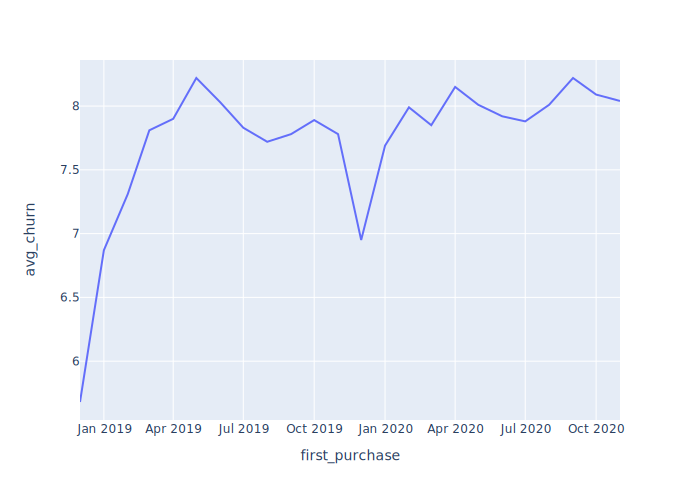

In [22]:
fig = px.line(retention, x ='first_purchase', y = 'avg_churn' )
fig.show('svg')

Мы видим, что со временем привлекаемый трафик становится все хуже, средний отток растет.

Также по месяцам видна определенная сезонность. Посмотрим на нее более подробно

In [23]:
retention['num_month'] =retention['first_purchase'].apply(lambda x: str(x)[5:7])

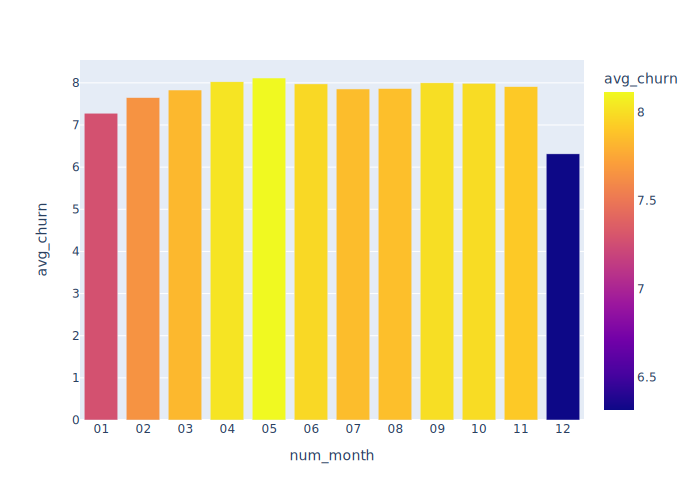

In [24]:
fig = px.bar(retention.groupby('num_month', as_index = False).agg({'avg_churn':'mean'}), 
             x ='num_month', y = 'avg_churn' , color='avg_churn')
fig.show('svg')

Пользователи, привлеченные в декабре и январе показывают лучший показатель оттока, а также пользователи, привлеченные летом, относительно оставшихся месяцев лучше сохраняют пользователя

In [25]:
df.head()

,order_time,order_id,product_id,sku_qty,category_id,category,brand_id,price,user_id,gender,c1,c2,c3
0,2018-12-01 11:40:29+00:00,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31+00:00,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42+00:00,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02+00:00,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond
4,2018-12-02 21:30:19+00:00,1925740842841014667,1873936840742928865,1,1.806829e+18,jewelry.necklace,0.0,417.67,1.515916e+18,NaN,red,gold,amethyst


#### Решим через sql

In [26]:
query = """ 
with cte as (
select 
    user_id,
    order_id,
    strftime('%Y-%m-01', order_time) as order_month,
    first_value(strftime('%Y-%m-01', order_time)) over (partition by user_id order by order_time ) as first_purchase
from
    df
) -- создаем представление с датами каждого заказа и первого месяца по каждому пользователю

select 
    --order_month, 
    O.first_purchase as first_purchase,
    --users_with_order,
    --regs,
    round(cast(users_with_order as float) / cast(regs as float)*100,2) as retention,
    strftime('%Y', order_month)*12+strftime('%m', order_month) -(strftime('%Y', O.first_purchase)*12+strftime('%m', O.first_purchase)) as months_after_reg
from
    (select 
        order_month, 
        first_purchase,
        count(distinct user_id ) as users_with_order
    from cte
    group by 1,2) as O
left join
    (select 
        first_purchase, 
        count(distinct user_id ) as regs
    from cte
    group by 1) as R on O.first_purchase = R.first_purchase
order by first_purchase, months_after_reg

    """

In [27]:
retention_sql = sqldf(query)
retention_sql.head()

,first_purchase,retention,months_after_reg
0,2018-12-01,100.00,0
1,2018-12-01,28.79,1
2,2018-12-01,36.36,2
3,2018-12-01,25.76,3
4,2018-12-01,24.24,4


### Repurchase
#### Через pandas

Посчитаем для каждого пользователя минимальную дату покупки

In [28]:
first_purch ['first_purchase'] = pd.to_datetime(first_purch.first_purchase.apply(lambda x: str(x)[:7] + '-01'))

Считаем количество заказов для каждого юзера, и если у юзера больше покупок чем 10, то мы заменим это количество на 10, чтобы избежать пропущенных значений

In [29]:
repurchase = df.groupby('user_id', as_index = False).agg({'order_id': 'nunique'}).rename(columns = {'order_id': 'orders'})
repurchase.head()

repurchase['orders'] = np.where(repurchase['orders'] >= 10, 10,repurchase['orders'])

Сджойним две таблицы и посчитаем, кол-во юзеров по дате регистрации и кол-ву покупок

In [30]:
repurchase = repurchase.merge(first_purch, how = 'left', on = 'user_id')\
        .groupby(['first_purchase','orders'], as_index = False).agg({'user_id':'nunique'})
repurchase.head()

,first_purchase,orders,user_id
0,2018-12-01,1,12
1,2018-12-01,2,11
2,2018-12-01,3,5
3,2018-12-01,4,8
4,2018-12-01,5,1


Подтянем общее количество клиентов по дате первой покупки

In [31]:
total_by_first_purch = first_purch.groupby('first_purchase', as_index = False )\
    .agg({'user_id':'count'})\
    .rename(columns = {'user_id':'total_users_by_reg'})

repurchase = repurchase.merge(total_by_first_purch, how = 'left', on = 'first_purchase')
repurchase.head()

,first_purchase,orders,user_id,total_users_by_reg
0,2018-12-01,1,12,66
1,2018-12-01,2,11,66
2,2018-12-01,3,5,66
3,2018-12-01,4,8,66
4,2018-12-01,5,1,66


Поскольку, repurchase rate мы считаем по логике минимального количества покупок, то количество пользователей для каждого количества покупок реализуем через накопленную сумму

In [32]:
repurchase = repurchase.sort_values(by = ['first_purchase', 'orders'], ascending = False)

In [33]:
repurchase['nakop'] = repurchase.groupby('first_purchase', as_index = False)\
    .user_id\
    .cumsum()

Посчитаем процент пользователей в группировке первая покупка + минимум покупок

In [34]:
repurchase['%_of_users'] = round((repurchase.nakop / repurchase.total_users_by_reg)*100,2)

In [35]:
repurchase = repurchase.pivot(index = 'first_purchase', columns = 'orders', values = '%_of_users').fillna(0)

In [36]:
repurchase

orders,1,2,3,4,5,6,7,8,9,10
first_purchase,,,,,,,,,,
2018-12-01,100.0,81.82,65.15,57.58,45.45,43.94,42.42,0.00,0.00,39.39
2019-01-01,100.0,70.74,55.85,46.81,40.96,31.91,29.26,27.13,23.40,22.87
2019-02-01,100.0,67.92,55.66,41.04,31.60,27.36,21.23,18.87,16.51,15.09
2019-03-01,100.0,63.59,39.32,28.16,19.42,16.02,13.11,11.17,9.71,7.77
2019-04-01,100.0,67.32,44.44,34.64,24.18,18.95,16.99,16.34,15.03,13.07
2019-05-01,100.0,60.53,40.79,27.63,20.39,17.11,13.82,10.53,7.89,6.58
2019-06-01,100.0,64.49,42.75,29.71,19.57,13.04,11.59,8.70,7.97,7.25
2019-07-01,100.0,58.14,41.40,31.63,19.53,13.95,10.70,9.30,6.51,5.58
2019-08-01,100.0,68.97,41.87,25.62,16.75,14.29,9.85,8.87,7.88,6.40


Мы видим, что в определенных когортах не встречалось какой-то группы минимального количества покупок, поэтому заменим их

In [37]:
for i in list(reversed(list(repurchase.columns)))[1:9]:
    repurchase[i] = np.where(repurchase[i] == 0,repurchase[i+1],repurchase[i] )

In [38]:
repurchase

orders,1,2,3,4,5,6,7,8,9,10
first_purchase,,,,,,,,,,
2018-12-01,100.0,81.82,65.15,57.58,45.45,43.94,42.42,39.39,39.39,39.39
2019-01-01,100.0,70.74,55.85,46.81,40.96,31.91,29.26,27.13,23.40,22.87
2019-02-01,100.0,67.92,55.66,41.04,31.60,27.36,21.23,18.87,16.51,15.09
2019-03-01,100.0,63.59,39.32,28.16,19.42,16.02,13.11,11.17,9.71,7.77
2019-04-01,100.0,67.32,44.44,34.64,24.18,18.95,16.99,16.34,15.03,13.07
2019-05-01,100.0,60.53,40.79,27.63,20.39,17.11,13.82,10.53,7.89,6.58
2019-06-01,100.0,64.49,42.75,29.71,19.57,13.04,11.59,8.70,7.97,7.25
2019-07-01,100.0,58.14,41.40,31.63,19.53,13.95,10.70,9.30,6.51,5.58
2019-08-01,100.0,68.97,41.87,25.62,16.75,14.29,9.85,8.87,7.88,6.40


Видно, что с каждым месяцем трафик с точки зрения повторных покупок становится менее качественным 

#### repurchase через sql

In [40]:
query = """ 
with cte as (
select 
    user_id,
    order_id,
    strftime('%Y-%m-01', order_time) as order_month,
    first_value(strftime('%Y-%m-01', order_time)) over (partition by user_id order by order_time ) as first_purchase
from
    df
) , cte_2 as (
select
    user_id,
    first_purchase,
    count(distinct order_id) as orders
from
    cte
group by 1,2
) -- для каждого юзера считаем кол-во заказов

select
    first_purchase,
    round(sum(one)/avg(total_users)* 100,2)  as '1',
    round(sum(two)/avg(total_users) * 100 , 2) as '2',
    round(sum(three)/avg(total_users) * 100, 2) as '3',
    round(sum(four)/avg(total_users) *100, 2) as '4',
    round(sum(five)/avg(total_users) * 100, 2) as '5',
    round(sum(six)/avg(total_users) * 100, 2) as '6',
    round(sum(seven)/avg(total_users) * 100, 2) as '7',
    round(sum(eight)/avg(total_users) * 100, 2)  as '8',
    round(sum(nine)/avg(total_users)*100,2) as '9',
    round(sum(ten)/avg(total_users) * 100, 2) as '10'
from
(
select 
   first_purchase,
   case when orders >= 1 then users_with_order else 0 end one,
   case when orders >= 2 then users_with_order else 0 end two,
   case when orders >= 3 then users_with_order else 0 end three,
   case when orders >= 4 then users_with_order else 0 end four,
   case when orders >= 5 then users_with_order else 0 end five,
   case when orders >= 6 then users_with_order else 0 end six,
   case when orders >= 7 then users_with_order else 0 end seven,
   case when orders >= 8 then users_with_order else 0 end eight,
   case when orders >= 9 then users_with_order else 0 end nine,
   case when orders >= 10 then users_with_order else 0 end ten,
   total_users
from  
    (
    select
        O.first_purchase as first_purchase,
        orders,
        users_with_order,
        total_users
    from 
        (select
           first_purchase as first_purchase,
           orders,
           count(distinct user_id) as users_with_order
        from cte_2
        group by 1,2) as O
    left join     
        (select
            first_purchase,
            count(distinct user_id ) as total_users
        from cte
        group by first_purchase) as R on O.first_purchase = R.first_purchase
        ) as main_table
) as t
group by first_purchase

"""


In [41]:
sqldf(query)

,first_purchase,1,2,3,4,5,6,7,8,9,10
0,2018-12-01,100.0,81.82,65.15,57.58,45.45,43.94,42.42,39.39,39.39,39.39
1,2019-01-01,100.0,70.74,55.85,46.81,40.96,31.91,29.26,27.13,23.40,22.87
2,2019-02-01,100.0,67.92,55.66,41.04,31.60,27.36,21.23,18.87,16.51,15.09
3,2019-03-01,100.0,63.59,39.32,28.16,19.42,16.02,13.11,11.17,9.71,7.77
4,2019-04-01,100.0,67.32,44.44,34.64,24.18,18.95,16.99,16.34,15.03,13.07
5,2019-05-01,100.0,60.53,40.79,27.63,20.39,17.11,13.82,10.53,7.89,6.58
6,2019-06-01,100.0,64.49,42.75,29.71,19.57,13.04,11.59,8.70,7.97,7.25
7,2019-07-01,100.0,58.14,41.40,31.63,19.53,13.95,10.70,9.30,6.51,5.58
8,2019-08-01,100.0,68.97,41.87,25.62,16.75,14.29,9.85,8.87,7.88,6.40
9,2019-09-01,100.0,64.00,42.00,32.67,26.00,19.33,13.33,11.33,10.00,7.33


#### Средний чек по категориям 

Посмотрим на пропущенные

In [42]:
df.isna().sum()

order_time         0
order_id           0
product_id         0
sku_qty            0
category_id        0
category        9837
brand_id        4675
price              0
user_id            0
gender         41044
c1              2045
c2               107
c3             27203
dtype: int64

Мы видим пропущенные значения в колонке category, но мы не будем их удалять, потому что мы можем восполнить их с помощью category_id

In [43]:
df_cats = df[['category_id', 'category']].drop_duplicates()

In [44]:
df.merge(df_cats, how = 'left', on = 'category_id').isna().sum()

order_time         0
order_id           0
product_id         0
sku_qty            0
category_id        0
category_x      9837
brand_id        4675
price              0
user_id            0
gender         41044
c1              2045
c2               107
c3             27203
category_y      9837
dtype: int64

Собрать категории по category_id не удалось, данных действительно нет. Поэтому удалим пропущенные значения

In [45]:
df.dropna(subset = ['category'], inplace = True)

In [46]:
df['order_month'] = pd.to_datetime(df.order_time.apply(lambda x: str(x)[:7] + '-01'))

Посчитаем для каждой категории в разрезе месяца средний чек

In [47]:
aov = df.groupby(['order_month', 'category', 'order_id'], as_index = False).agg({'price':'sum'})\
            .groupby(['order_month', 'category'], as_index = False).agg({'price' : 'mean'})

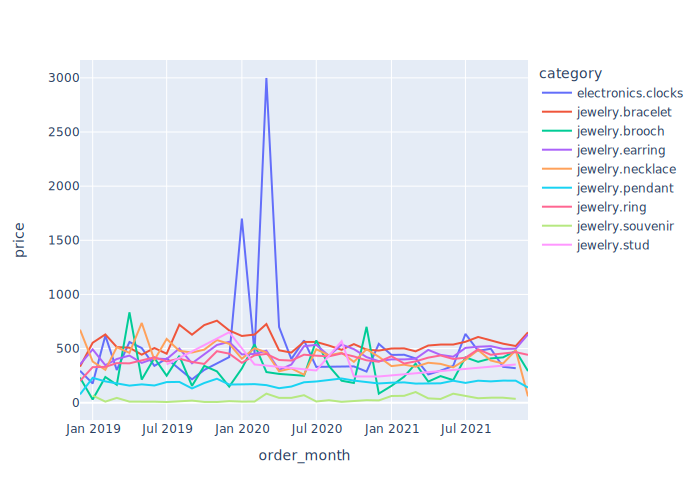

In [48]:
fig = px.line(aov, x = 'order_month', y = 'price', color = 'category')
fig.show('svg')

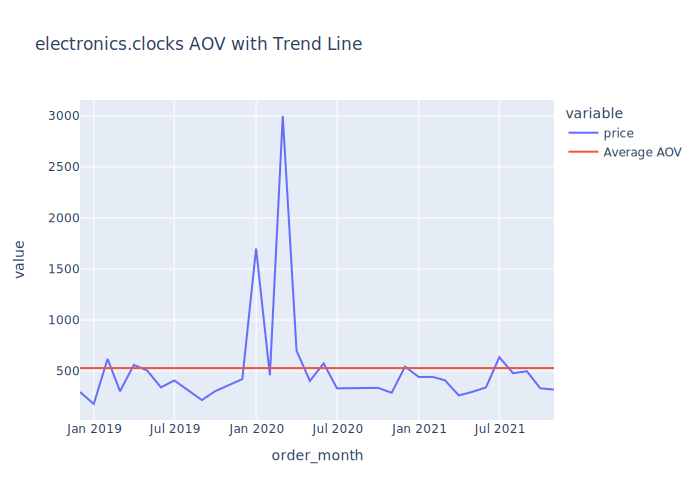

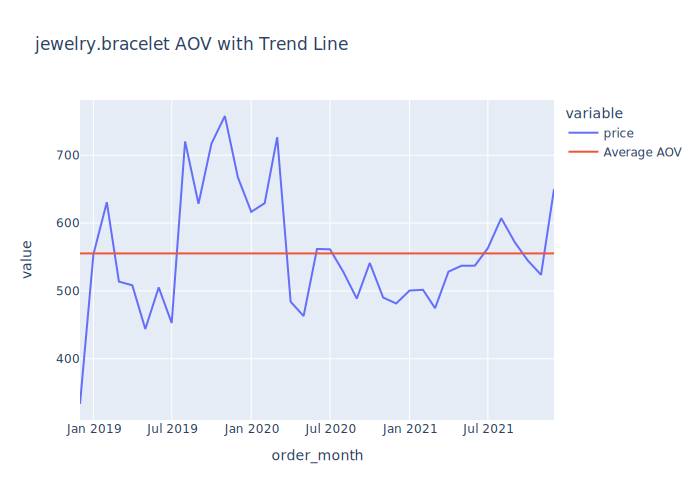

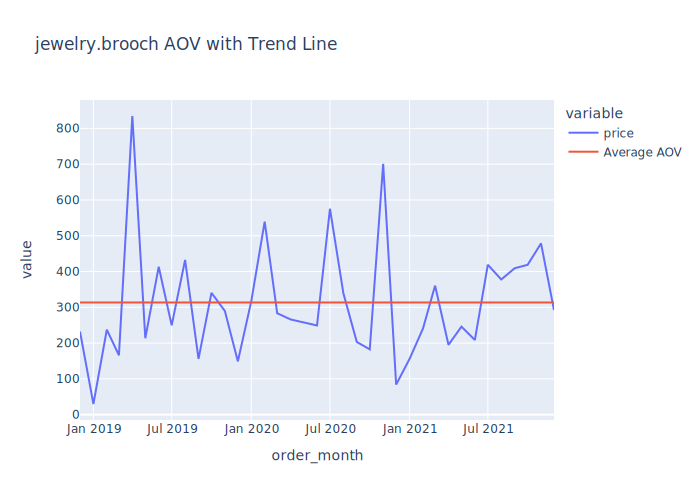

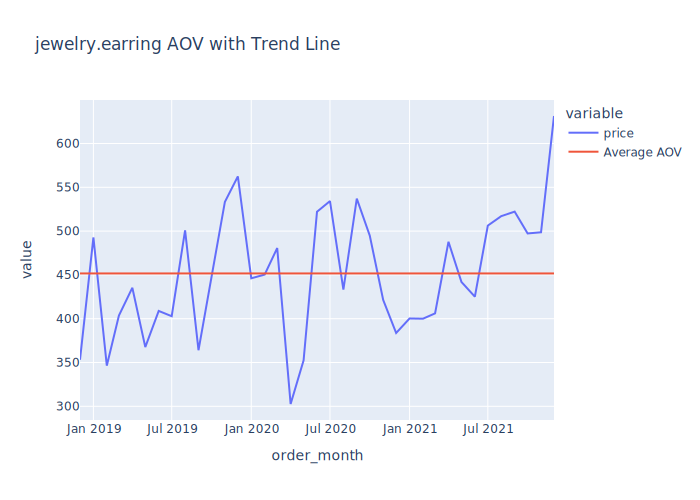

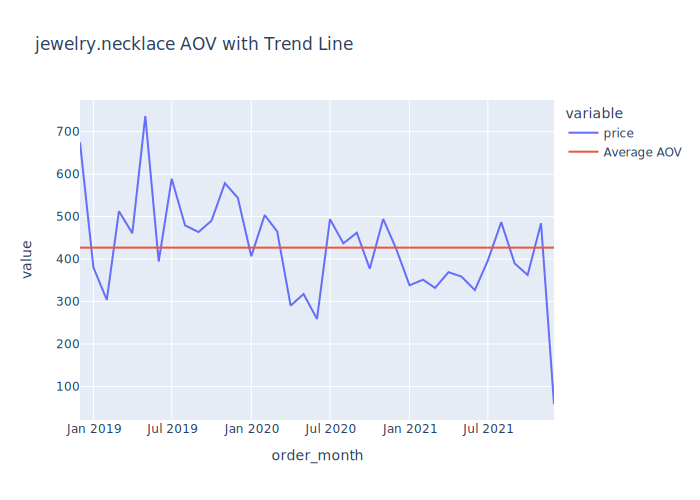

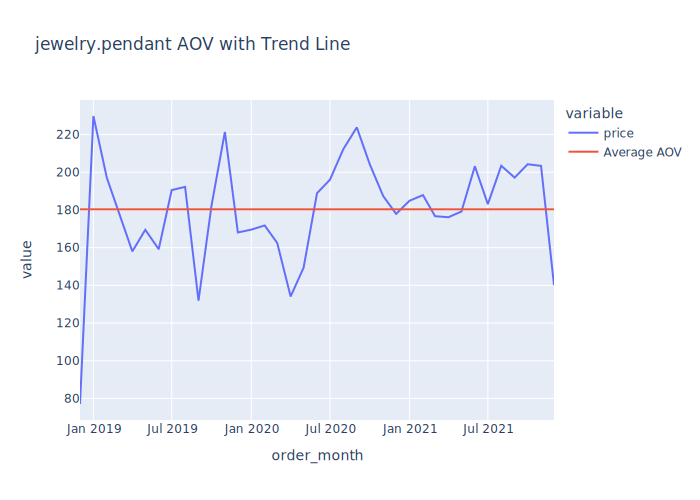

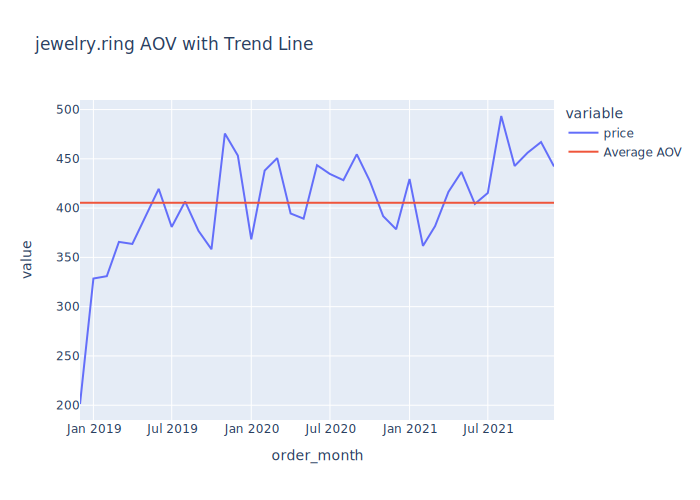

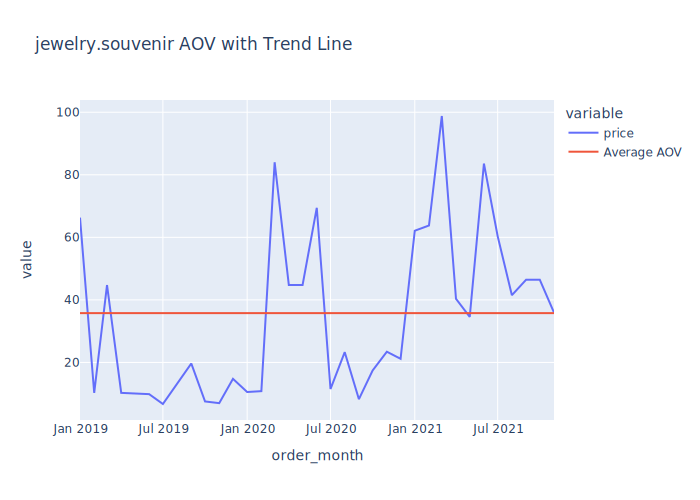

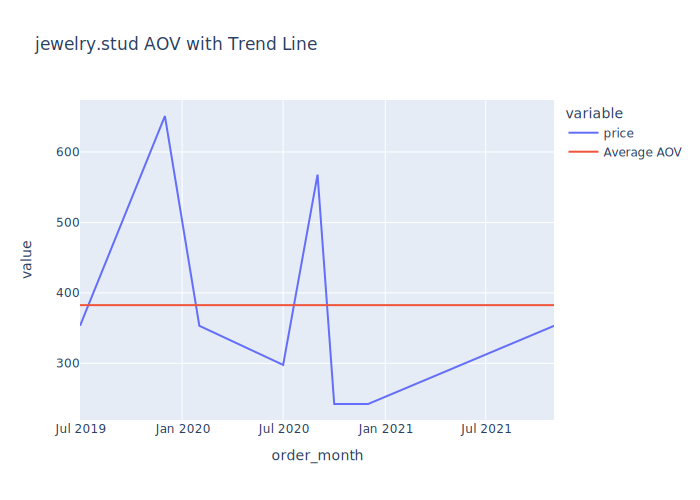

In [49]:
for category in aov.category.unique():
    df_category = aov.loc[aov["category"] == category].copy()
    df_category["Average AOV"] = round(df_category["price"].mean(), 2)
    category_graph = px.line(
    df_category, 
    x="order_month", 
    y=["price", "Average AOV"], 
    title=f"{category} AOV with Trend Line"
    )
    category_graph.show('svg')